# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

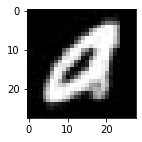

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [5]:
#torch.tensor(pic)

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

## Основные задания

импортнем все необходимое и создадим датасет с необходимыми преобразованиями

In [6]:
import os
import time
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

In [7]:
def get_data_and_targets_lst(path):
    data=[]
    targets=[]
    for root, currentDirectory, files in os.walk(path):
        for file in files:
            pic = plt.imread(os.path.join(root, file))
            pic = torch.tensor(np.transpose(pic, axes=(1, 0, 2)))
            pic = torch.div(pic, 255)
            target = ord(file[0]) - ord('a')
            data.append(pic)
            targets.append(target)
    return data,targets

In [8]:
class MyDataset(torch.utils.data.Dataset): 
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        #return {'sample': self.x[idx], 'target': self.y[idx]}
        return self.x[idx],self.y[idx]

In [9]:
X,y = get_data_and_targets_lst("images/train")

Да, я знаю про ImageFolder только узнал про него под конец сдачи лабы и не успел заиспользовать. Буду юзать в следующих лабах.

In [10]:
X[60000].dtype

torch.float32

15


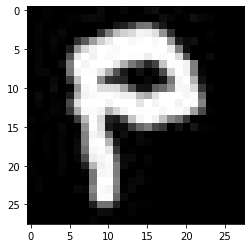

In [11]:
plt.imshow(X[60000])
print(y[60000])

In [12]:
len(y)

65000

разобьем трейн выборку на трейн и тест. Да, здесь получается небольшая тавтология

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [14]:
len(X_test), len(y_test)

(13000, 13000)

In [15]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
#train_dataset.__getitem__(40000)

In [16]:
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)
    print(y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    #NHWC now
    print("Shape of y: ", y.shape, y.dtype)
    break

0
tensor([ 6, 16, 14,  7, 19,  8, 22, 20,  7,  4,  7, 25, 24,  7, 14, 12,  0, 16,
         1,  5,  5,  1, 15, 25,  7,  4,  9, 18, 14,  6,  8,  7,  3, 20,  2, 22,
         5,  7, 17, 25, 14, 12, 15, 25,  2, 16,  6, 15, 11, 16, 17,  8,  0, 23,
        17, 11,  0, 14, 11,  0,  0,  2,  4, 18])
Shape of X [N, C, H, W]:  torch.Size([64, 28, 28, 3])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


определяем, необходимые для цикла обучения, функции

In [18]:
def train(dataloader, model, loss_fn, optimizer, to_NCHW = False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if to_NCHW:
            X = X.permute(0, 3, 1, 2)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(pred.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_fn, to_NCHW = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            if to_NCHW:
                X = X.permute(0, 3, 1, 2)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred.shape)
            #print(loss_fn(pred, y).item())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [20]:
def get_model_accuracy(dataloader, model, to_NCHW = False):
    size = len(dataloader.dataset)
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            if to_NCHW:
                X = X.permute(0, 3, 1, 2)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct / size       

In [21]:
def get_all_model_predictions(dataloader, model):
    size = len(dataloader.dataset)
    correct = 0
    predictions = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predictions.extend(pred.argmax(1))
#             if len(pred.argmax(1))>1:
#                 print(pred.argmax(1))
    return list(map(lambda x : x.item(), predictions)) 

In [22]:
def learning_cycle(epochs, model, loss_fn, optimizer, to_NCHW = False):
    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        starttm = time.time()
        train(train_dataloader, model, loss_fn, optimizer, to_NCHW = to_NCHW)
        test(test_dataloader, model, loss_fn, to_NCHW = to_NCHW)
        endtm = time.time()
        print(f"Time: {(endtm - starttm):>0.3f}")
        #print("Done!")
    

# 1.1

попробуем создать первую модель

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [24]:
model_lin3 = NeuralNetwork()

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lin3.parameters(), lr=0.01)
learning_cycle(20, model_lin3, loss_fn, optimizer)


Epoch 1
-------------------------------
loss: 3.255079  [    0/52000]
loss: 3.245245  [ 6400/52000]
loss: 3.247203  [12800/52000]
loss: 3.242728  [19200/52000]
loss: 3.229711  [25600/52000]
loss: 3.211757  [32000/52000]
loss: 3.175838  [38400/52000]
loss: 3.133849  [44800/52000]
loss: 3.106009  [51200/52000]
Test Error: 
 Accuracy: 21.7%, Avg loss: 3.067684
Time: 16.463

Epoch 2
-------------------------------
loss: 3.045726  [    0/52000]
loss: 2.921689  [ 6400/52000]
loss: 2.774934  [12800/52000]
loss: 2.647703  [19200/52000]
loss: 2.393272  [25600/52000]
loss: 2.363592  [32000/52000]
loss: 1.848715  [38400/52000]
loss: 2.008251  [44800/52000]
loss: 1.824672  [51200/52000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.710188
Time: 16.521

Epoch 3
-------------------------------
loss: 1.689673  [    0/52000]
loss: 1.323161  [ 6400/52000]
loss: 1.712483  [12800/52000]
loss: 1.670516  [19200/52000]
loss: 1.521037  [25600/52000]
loss: 1.564165  [32000/52000]
loss: 1.242678  [38400/52000]
l

учиться довольно медленно но +-стабильно

In [26]:
X_train[0].shape

torch.Size([28, 28, 3])

In [27]:
pred = model_lin3(X_train[30000].reshape([1,28,28,3]))

In [28]:
pred,y_train[30000]

(tensor([[  2.1948,   5.8896,  13.2519,   4.2528,  13.3028,  -6.2386,   0.7841,
           -8.1126,   2.2034,  -1.2103,   0.8520,   4.6672,  -6.9980,  -2.2155,
            4.5022, -14.6413,   0.2363,   2.8631,   3.2576,   7.0897,  -4.5050,
           -9.6243,  -8.6572,  -4.0066,  -5.7131,   7.4510]],
        grad_fn=<AddmmBackward0>),
 2)

ради эксперимента создадим сеточку с двумя линейными слоями

In [29]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.Sigmoid(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

In [30]:
model_lin2 = NeuralNetwork2()

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model_lin2.parameters(), lr=0.01)
learning_cycle(10, model_lin2, loss_fn, optimizer2)


Epoch 1
-------------------------------
loss: 3.316017  [    0/52000]
loss: 3.232385  [ 6400/52000]
loss: 3.188402  [12800/52000]
loss: 3.164689  [19200/52000]
loss: 3.126134  [25600/52000]
loss: 3.094627  [32000/52000]
loss: 3.025605  [38400/52000]
loss: 2.996710  [44800/52000]
loss: 2.931988  [51200/52000]
Test Error: 
 Accuracy: 40.7%, Avg loss: 2.913264
Time: 6.282

Epoch 2
-------------------------------
loss: 2.934039  [    0/52000]
loss: 2.810050  [ 6400/52000]
loss: 2.783159  [12800/52000]
loss: 2.765012  [19200/52000]
loss: 2.685134  [25600/52000]
loss: 2.662539  [32000/52000]
loss: 2.478028  [38400/52000]
loss: 2.487883  [44800/52000]
loss: 2.418555  [51200/52000]
Test Error: 
 Accuracy: 49.3%, Avg loss: 2.367038
Time: 6.356

Epoch 3
-------------------------------
loss: 2.397222  [    0/52000]
loss: 2.166404  [ 6400/52000]
loss: 2.253088  [12800/52000]
loss: 2.280523  [19200/52000]
loss: 2.190848  [25600/52000]
loss: 2.207898  [32000/52000]
loss: 1.969377  [38400/52000]
los

судя по всему более простая модель только с двумя линейными слоями и учится значительно быстрее и выдает результаты далеко не хуже с точки зрения метрик

так же большое значение играет здесь learning rate 

прогоним на тестовой выборке

In [32]:
Xt,yt = get_data_and_targets_lst("images/test")

In [33]:
final_test_dataset = MyDataset(Xt, yt)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=batch_size)

In [34]:
get_model_accuracy(final_test_dataloader, model_lin3)

0.8731538461538462

In [35]:
get_model_accuracy(final_test_dataloader, model_lin2)

0.6465384615384615

In [36]:
#torch.save(model_lin2.state_dict(), "my_models/model90.pth")

In [37]:
# model_lin2 = NeuralNetwork2()
# model_lin2.load_state_dict(torch.load("my_models/model90.pth"))

# 1.2

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

достанем одну из обученных мной линейных моделей

In [39]:
model_lin2 = NeuralNetwork2()
model_lin2.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [40]:
predictions = get_all_model_predictions(final_test_dataloader, model_lin2)
len(predictions)

13000

In [41]:
print(13000/26)

500.0


In [42]:
cf_matrix = confusion_matrix(yt, predictions)

<AxesSubplot:>

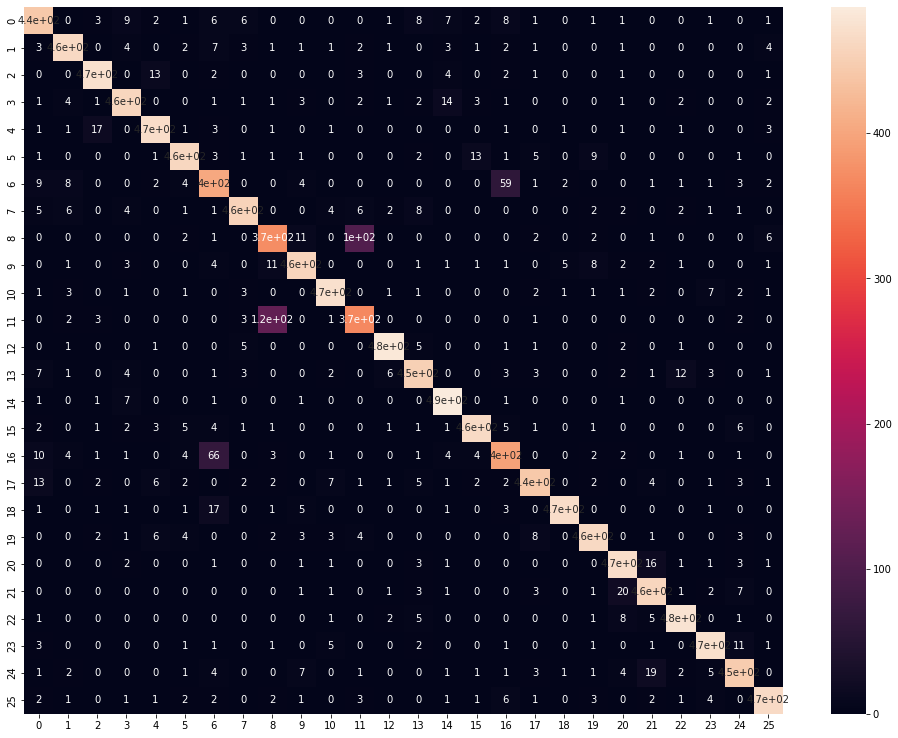

In [43]:
plt.figure(figsize=(17,13))
sns.heatmap(cf_matrix, annot=True)

<BarContainer object of 26 artists>

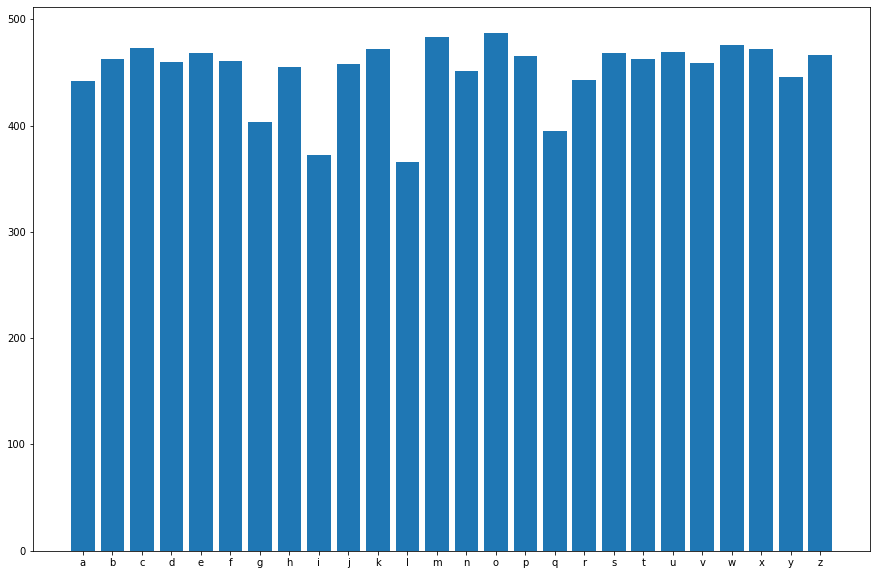

In [44]:
plt.figure(figsize=(15,10))
letters_stat = [cf_matrix[i][i] for i in range(26)]
plt.bar([chr(i+97) for i in range(26)], letters_stat)

буквы с наибольшей и наименьшей статистикой угадывания

In [45]:
chr(np.array(letters_stat).argmax() + 97), max(letters_stat)/500

('o', 0.974)

In [46]:
chr(np.array(letters_stat).argmin() + 97), min(letters_stat)/500

('l', 0.732)

если прогонять на самой лучшей модели - то лучше всего угадывается "o" хуже всего - "i" и "l"

предположительно, потому что у О очень простая структура (просто кружок) и что гораздо более важное - заглавная и строчная версия буквы никак не отличаются, чего не скажешь о "i"  или, например об "q"

# 1.3

In [47]:
def get_confusing_letters(cf_matrix, amount=10):
    matrix = cf_matrix.copy()
    for i in range(26):
        matrix[i][i] = 0
    confusion = []
    for i in range(26):
        for j in range(26):
            if len(confusion)<amount:
                confusion.append((matrix[i][j],chr(i+97),chr(j+97)))
            elif min(confusion, key=lambda el: el[0])[0] < matrix[i][j]:
                confusion = sorted(confusion, key=lambda el: el[0])
                confusion[0] = (matrix[i][j],chr(i+97),chr(j+97))
    return sorted(confusion, key=lambda el: el[0])

In [48]:
get_confusing_letters(cf_matrix, 20)

[(9, 'f', 't'),
 (9, 'a', 'd'),
 (10, 'q', 'a'),
 (11, 'x', 'y'),
 (11, 'j', 'i'),
 (11, 'i', 'j'),
 (12, 'n', 'w'),
 (13, 'r', 'a'),
 (13, 'f', 'p'),
 (13, 'c', 'e'),
 (14, 'd', 'o'),
 (16, 'u', 'v'),
 (17, 's', 'g'),
 (17, 'e', 'c'),
 (19, 'y', 'v'),
 (20, 'v', 'u'),
 (59, 'g', 'q'),
 (66, 'q', 'g'),
 (103, 'i', 'l'),
 (122, 'l', 'i')]

In [49]:
wrong_inds = []
for i in range(len(predictions)):
    if predictions[i] != yt[i]:
        wrong_inds.append(i)

In [50]:
#wrong_inds

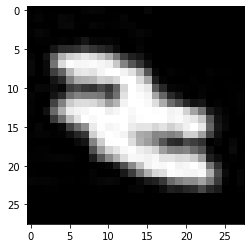

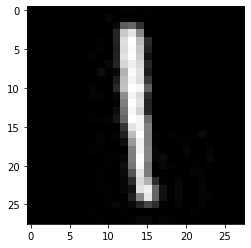

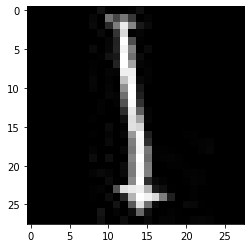

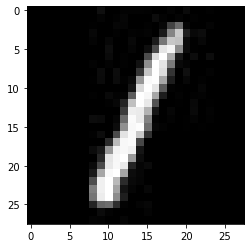

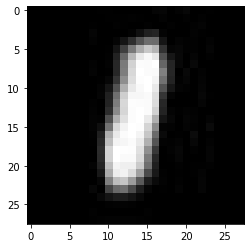

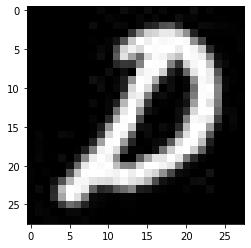

In [51]:
for i in [5,100,123,34,300,1200]:
    plt.imshow(Xt[wrong_inds[i]])
    plt.show()

как мы видим большинство букв тяжело опознаваемы даже для человека 

# 1.4 

In [52]:
sind = ord("s") - 97
cf_matrix[sind][sind]/500

0.936

In [53]:
sind

18

судя по confusion_matrix чаще всего модель путает букву "s" с буквами под номерами 6 и 9

In [54]:
chr(97+6), chr(97+9)

('g', 'j')

# 2

In [55]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 18, 5)

In [56]:
for batch, (X, y) in enumerate(train_dataloader):
    X = X.permute(0, 3, 1, 2)
    print(X.shape)
    X = conv1(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv2(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 6, 24, 24])
torch.Size([64, 6, 12, 12])
torch.Size([64, 18, 8, 8])
torch.Size([64, 18, 4, 4])


In [57]:
class Conv2NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv2NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(6, 18, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*4*4,120),
            nn.ReLU(),
            nn.Linear(120,26)
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [58]:
for batch, (X, y) in enumerate(train_dataloader):
    c = Conv2NeuralNetwork()
    print(c(X.permute(0, 3, 1, 2)).shape)
    break

torch.Size([64, 26])


In [59]:
model_conv2 = Conv2NeuralNetwork()

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv2.parameters(), lr=0.001)
learning_cycle(20, model_conv2, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.266386  [    0/52000]
loss: 3.264105  [ 6400/52000]
loss: 3.251246  [12800/52000]
loss: 3.268612  [19200/52000]
loss: 3.259354  [25600/52000]
loss: 3.261800  [32000/52000]
loss: 3.260221  [38400/52000]
loss: 3.260473  [44800/52000]
loss: 3.252666  [51200/52000]
Test Error: 
 Accuracy: 3.9%, Avg loss: 3.254566
Time: 6.548

Epoch 2
-------------------------------
loss: 3.258466  [    0/52000]
loss: 3.254683  [ 6400/52000]
loss: 3.244382  [12800/52000]
loss: 3.262465  [19200/52000]
loss: 3.250807  [25600/52000]
loss: 3.253352  [32000/52000]
loss: 3.253204  [38400/52000]
loss: 3.257144  [44800/52000]
loss: 3.241843  [51200/52000]
Test Error: 
 Accuracy: 3.9%, Avg loss: 3.244927
Time: 6.322

Epoch 3
-------------------------------
loss: 3.249088  [    0/52000]
loss: 3.242886  [ 6400/52000]
loss: 3.233449  [12800/52000]
loss: 3.252773  [19200/52000]
loss: 3.237284  [25600/52000]
loss: 3.239924  [32000/52000]
loss: 3.240725  [38400/52000]
loss:

модель учится лучше линейной, но по опыту сильно лучших результатов (более 92 процентов акьюраси она не достигнет)

когда я только начинал разбираться в лабе - я прогонял линейные модели по сотням эпох и вяснил, что при должном усердии они тоже могут дойти до 90% но на это уйдет значительно больше эпох. Побороть отметку в 91.2 или около того мне пока не удалось

In [61]:
conv1 = nn.Conv2d(3, 8, 3)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(8, 16, 4)
conv3 = nn.Conv2d(16, 18, 2)

In [62]:
for batch, (X, y) in enumerate(train_dataloader):
    X = X.permute(0, 3, 1, 2)
    print(X.shape)
    X = conv1(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv2(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    X = conv3(X)
    print(X.shape)
    X = pool(X)
    print(X.shape)
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 8, 26, 26])
torch.Size([64, 8, 13, 13])
torch.Size([64, 16, 10, 10])
torch.Size([64, 16, 5, 5])
torch.Size([64, 18, 4, 4])
torch.Size([64, 18, 2, 2])


In [63]:
class Conv3NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [64]:
model_conv3 = Conv3NeuralNetwork()

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.258197  [    0/52000]
loss: 3.260607  [ 6400/52000]
loss: 3.263326  [12800/52000]
loss: 3.259893  [19200/52000]
loss: 3.253541  [25600/52000]
loss: 3.253062  [32000/52000]
loss: 3.263047  [38400/52000]
loss: 3.265059  [44800/52000]
loss: 3.261517  [51200/52000]
Test Error: 
 Accuracy: 3.9%, Avg loss: 3.257892
Time: 6.767

Epoch 2
-------------------------------
loss: 3.254370  [    0/52000]
loss: 3.255326  [ 6400/52000]
loss: 3.256018  [12800/52000]
loss: 3.254397  [19200/52000]
loss: 3.250374  [25600/52000]
loss: 3.249504  [32000/52000]
loss: 3.255481  [38400/52000]
loss: 3.257264  [44800/52000]
loss: 3.254663  [51200/52000]
Test Error: 
 Accuracy: 8.5%, Avg loss: 3.251055
Time: 6.686

Epoch 3
-------------------------------
loss: 3.247858  [    0/52000]
loss: 3.247155  [ 6400/52000]
loss: 3.243324  [12800/52000]
loss: 3.243543  [19200/52000]
loss: 3.239605  [25600/52000]
loss: 3.236536  [32000/52000]
loss: 3.231131  [38400/52000]
loss:

In [66]:
get_model_accuracy(final_test_dataloader, model_conv3, to_NCHW=True)

0.8872307692307693

In [67]:
#torch.save(model_conv3.state_dict(), "my_models/model91conv3.pth")

In [68]:
class Conv1NeuralNetwork(nn.Module):
    def __init__(self):
        super(Conv1NeuralNetwork, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24*24*6,1024),
            nn.ReLU(),
            nn.Linear(1024,26)
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

на этом этапе тренировать сетку с одной сверткой уже не интересно, потому что очевидно, что результаты она покажет ощутимо хуже

In [69]:
class Conv3NeuralNetworkBN(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetworkBN, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Ни одну сетку у меня не получилось доучить более чем на 91 процента accuracy

следующим этапом будут эксперименты с размером батча

In [70]:
class Conv3NeuralNetworkGN(nn.Module):
    def __init__(self):
        super(Conv3NeuralNetworkGN, self).__init__()
        self.convolution_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.MaxPool2d(2, 2),
            nn.GroupNorm(4,8),
            nn.Conv2d(8, 16, 4),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 18, 2),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18*2*2,64),
            nn.ReLU(),
            nn.Linear(64,48),
            nn.ReLU(),
            nn.Linear(48,26),
        )
    def forward(self, x):
        x = self.convolution_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [71]:
model_conv3 = Conv3NeuralNetworkGN()

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.269928  [    0/52000]
loss: 3.248653  [ 6400/52000]
loss: 3.246495  [12800/52000]
loss: 3.256890  [19200/52000]
loss: 3.240327  [25600/52000]
loss: 3.219076  [32000/52000]
loss: 3.197245  [38400/52000]
loss: 3.161981  [44800/52000]
loss: 3.053715  [51200/52000]
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.962082
Time: 3.573

Epoch 2
-------------------------------
loss: 2.976711  [    0/52000]
loss: 2.354831  [ 6400/52000]
loss: 2.113627  [12800/52000]
loss: 2.053387  [19200/52000]
loss: 1.646647  [25600/52000]
loss: 1.610824  [32000/52000]
loss: 1.336667  [38400/52000]
loss: 1.355398  [44800/52000]
loss: 1.338440  [51200/52000]
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.259590
Time: 3.589

Epoch 3
-------------------------------
loss: 1.230191  [    0/52000]
loss: 0.870172  [ 6400/52000]
loss: 1.118220  [12800/52000]
loss: 1.126180  [19200/52000]
loss: 0.873215  [25600/52000]
loss: 1.010709  [32000/52000]
loss: 0.734253  [38400/52000]
los

In [73]:
batch_size=258
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [74]:
model_conv3 = Conv3NeuralNetworkBN()

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.01)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 3.256098  [    0/52000]
loss: 3.255288  [25800/52000]
loss: 3.255895  [51600/52000]
Test Error: 
 Accuracy: 4.5%, Avg loss: 3.248836
Time: 4.763

Epoch 2
-------------------------------
loss: 3.241888  [    0/52000]
loss: 3.239928  [25800/52000]
loss: 3.230184  [51600/52000]
Test Error: 
 Accuracy: 6.2%, Avg loss: 3.224404
Time: 5.070

Epoch 3
-------------------------------
loss: 3.217433  [    0/52000]
loss: 3.201406  [25800/52000]
loss: 3.144265  [51600/52000]
Test Error: 
 Accuracy: 10.9%, Avg loss: 3.144570
Time: 3.267

Epoch 4
-------------------------------
loss: 3.138539  [    0/52000]
loss: 3.010402  [25800/52000]
loss: 2.585767  [51600/52000]
Test Error: 
 Accuracy: 27.4%, Avg loss: 2.616976
Time: 3.373

Epoch 5
-------------------------------
loss: 2.566278  [    0/52000]
loss: 2.152303  [25800/52000]
loss: 1.805682  [51600/52000]
Test Error: 
 Accuracy: 45.0%, Avg loss: 1.844934
Time: 3.833

Epoch 6
----------------------------

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv3.parameters(), lr=0.001)
learning_cycle(20, model_conv3, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 0.371872  [    0/52000]
loss: 0.517468  [25800/52000]
loss: 0.370761  [51600/52000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.452488
Time: 2.760

Epoch 2
-------------------------------
loss: 0.361483  [    0/52000]
loss: 0.516105  [25800/52000]
loss: 0.371907  [51600/52000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.450930
Time: 2.847

Epoch 3
-------------------------------
loss: 0.360284  [    0/52000]
loss: 0.514777  [25800/52000]
loss: 0.371979  [51600/52000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.449557
Time: 2.654

Epoch 4
-------------------------------
loss: 0.359270  [    0/52000]
loss: 0.513382  [25800/52000]
loss: 0.371507  [51600/52000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.448262
Time: 2.730

Epoch 5
-------------------------------
loss: 0.358258  [    0/52000]
loss: 0.512045  [25800/52000]
loss: 0.370852  [51600/52000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.446996
Time: 2.841

Epoch 6
--------------------------

# 3

здесь загрузим пару моделей из обученных мной и продемонстрируем результаты на тестовых данных

In [77]:
model90 = NeuralNetwork2()
model90.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [78]:
get_model_accuracy(final_test_dataloader, model90)

0.9027692307692308

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

# B1

я написал все буквы черной ручкой на белом листочке, больше всего меня интересовали q и p

In [79]:
model90 = Conv3NeuralNetwork()
model90.load_state_dict(torch.load("my_models/model91conv3.pth"))

<All keys matched successfully>

In [80]:
model90n = NeuralNetwork2()
model90n.load_state_dict(torch.load("my_models/model90.pth"))

<All keys matched successfully>

In [81]:
mX,my = get_data_and_targets_lst("custom_images")

In [82]:
my

[16, -49, -49, -49, 25, 0, 12, 15]

In [83]:
for el in mX:
    print(el.shape)

torch.Size([1080, 1012, 3])
torch.Size([120, 121, 3])
torch.Size([144, 141, 3])
torch.Size([127, 93, 3])
torch.Size([958, 1080, 3])
torch.Size([1043, 1080, 3])
torch.Size([936, 1080, 3])
torch.Size([1034, 1080, 3])


In [84]:
import cv2

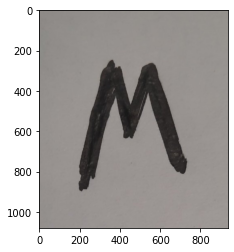

In [85]:
image = plt.imread('custom_images/m.jpg')
plt.imshow(image)

plt.show()

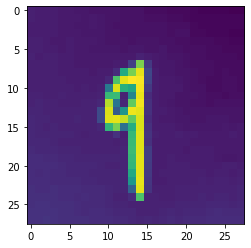

In [86]:
image = cv2.imread('custom_images/q.jpg')
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = cv2.resize(image, (28,28), interpolation=cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image= np.invert(image)
plt.imshow(image)
plt.show()

In [87]:
result = np.zeros([28, 28, 3])

In [88]:
for i in range(28):
    for j in range(28):
        result[i][j][0] = image[i][j]/255
        result[i][j][1] = image[i][j]/255
        result[i][j][2] = image[i][j]/255

In [89]:
result = torch.from_numpy(result)
result = result.float()
result.dtype

torch.float32

In [90]:
res_tens = model90(result.reshape([1,3,28,28]))

In [91]:
res_tens.argmax(1)

tensor([16])

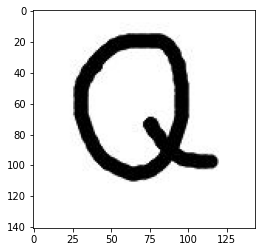

In [92]:
image = plt.imread('custom_images/0q.jpg')
plt.imshow(image)

plt.show()

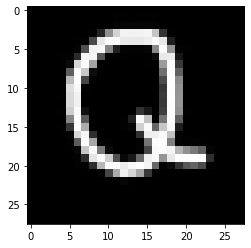

In [93]:
image = cv2.imread('custom_images/0q.jpg')

image = cv2.resize(image, (28,28), interpolation=cv2.INTER_AREA)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image= np.invert(image)
plt.imshow(image)
plt.show()

In [94]:
image = torch.tensor(image)
image = torch.div(image, 255)

In [95]:
res_tens = model90(image.reshape([1,3,28,28]))
res_tens.argmax(1)

tensor([16])

In [96]:
ord("a") - 97

0

In [97]:
ord("q") - 97

16

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

In [98]:
import torchvision.models as models

In [99]:
resnet = models.resnet18(pretrained=True)

In [100]:
get_model_accuracy(final_test_dataloader, resnet, to_NCHW=True)

0.0005384615384615384

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
learning_cycle(5, resnet, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 0.758218  [    0/52000]
loss: 0.493638  [25800/52000]
loss: 0.239704  [51600/52000]
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.304458
Time: 317.035

Epoch 2
-------------------------------
loss: 0.359558  [    0/52000]
loss: 0.248963  [25800/52000]
loss: 0.133313  [51600/52000]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.270151
Time: 233.447

Epoch 3
-------------------------------
loss: 0.230445  [    0/52000]
loss: 0.158834  [25800/52000]
loss: 0.090643  [51600/52000]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.266355
Time: 233.689

Epoch 4
-------------------------------
loss: 0.146766  [    0/52000]
loss: 0.108655  [25800/52000]
loss: 0.058887  [51600/52000]
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.277372
Time: 243.391

Epoch 5
-------------------------------
loss: 0.094430  [    0/52000]


KeyboardInterrupt: 

In [104]:
#get_model_accuracy(final_test_dataloader, resnet, to_NCHW=True)

In [105]:
#resnet.load_state_dict(torch.load("my_models/my_resnet.pth"))

In [106]:
resnet = models.resnet18(pretrained=False)

In [107]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01)
learning_cycle(10, resnet, loss_fn, optimizer, to_NCHW=True)


Epoch 1
-------------------------------
loss: 7.220859  [    0/52000]
loss: 0.774197  [25800/52000]
loss: 0.361706  [51600/52000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.518272
Time: 229.935

Epoch 2
-------------------------------
loss: 0.444768  [    0/52000]
loss: 0.358738  [25800/52000]
loss: 0.206440  [51600/52000]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.353534
Time: 237.172

Epoch 3
-------------------------------
loss: 0.271081  [    0/52000]
loss: 0.234415  [25800/52000]
loss: 0.155855  [51600/52000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.304680
Time: 240.516

Epoch 4
-------------------------------
loss: 0.192522  [    0/52000]
loss: 0.173289  [25800/52000]
loss: 0.129491  [51600/52000]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.287987
Time: 236.660

Epoch 5
-------------------------------
loss: 0.156693  [    0/52000]
loss: 0.131325  [25800/52000]
loss: 0.108521  [51600/52000]
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.278547
Time: 234.111

Epoch 6
----------------

In [110]:
get_model_accuracy(final_test_dataloader, resnet, to_NCHW=True)

0.916923076923077

In [112]:
torch.save(resnet.state_dict(), "my_models/resnet18my.pth")

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.